In [ ]:
%matplotlib inline

import os
import sys 
import random

import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from PIL import Image
from PIL import ImageOps

sys.path.append(os.path.abspath("/home/himani/memory_augmented_neural_net"))
from utils import OmniglotDataLoader, one_hot_decode, five_hot_decode
from model import NTMOneShotLearningModel

### Data Exploration

In [163]:
dataloader=OmniglotDataLoader()
test=dataloader.test_data

In [164]:
print(type(test))
print(len(test))

<type 'list'>
423


In [165]:
x=test[0]
print(type(x))
print(len(x))
print(type(x[0]))

y=np.asarray(x[0])
print(y.shape)

<type 'list'>
20
<class 'PIL.Image.Image'>
(105, 105)


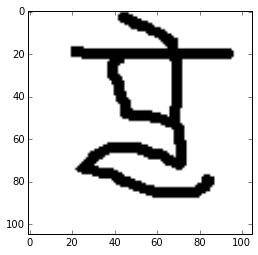

In [166]:
plt.imshow(x[0]) #grayscale image

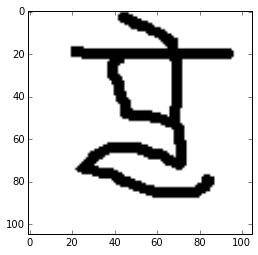

In [167]:
x_binary = x[0].convert('L')
plt.imshow(x_binary,cmap='gray') #binary image

In [176]:
x_np=np.array(x_binary, dtype=np.float32)
print(x_np.shape)
print(np.unique(x_np))

(105, 105)
[   0.  255.]


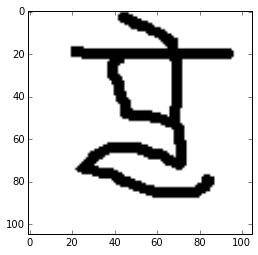

In [177]:
plt.imshow(x_np,cmap='gray')

In [169]:
max_value = np.max(x_np)    # normalization is important

print(max_value)
if max_value > 0.:
    x_scale = x_np / max_value
    
print(np.unique(x_scale))

255.0
[ 0.  1.]


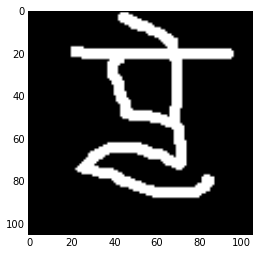

In [18]:
x_invert = ImageOps.invert(x_binary)
plt.imshow(x_invert,cmap='gray')

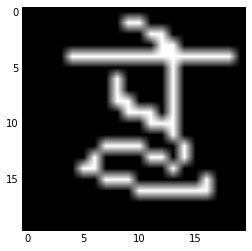

In [20]:
x_resize=x_invert.resize((20,20))
plt.imshow(x_resize,cmap='gray')

In [27]:
x_np2=np.array(x_resize, dtype=np.float32)
x_np2

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         255.,  255.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  255.,  255.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  255.,  255.,    0.,    0.,    0.,    0.,
           0.,    0.],
       [   0.,    0.,    0.,    0.,  255.,  255.,  255.,  255.,  255.,
         255.,  255.,  255.,  255.,  255.,  255.,  255.,  255.,  255.,
         255.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,  255.,    0.,    0.,    0.,    0.,
           0.,    0.],
       [  

In [42]:
a=np.random.rand() #gives [0,1]
#we need (-pi/16, +pi/16)
b=a-0.5
c=b*22.5
print('%f -> %f -> %f'%(a,b,c))

0.334232 -> -0.165768 -> -3.729779


2.44876270991
(105, 105)


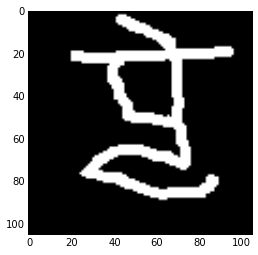

In [103]:
max_rotate=7 #7 degrees
rand_rotate=(np.random.rand()-0.5)*2*max_rotate # (-pi/16, +pi/16) -> (-11 deg , +11 deg)
print(rand_rotate)

x_rotate=x_invert.rotate(rand_rotate)
plt.imshow(x_rotate,cmap='gray')

print(x_rotate.size)

[ 6.65886129 -5.6793335 ]
(105, 105)


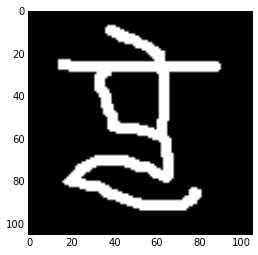

In [104]:
max_translate=7
rand_translate=(np.random.rand(2)-0.5)*2*max_translate # (-7,7) -> (x_translation,y_translation)
print(rand_translate)

#(x,y) -> (ax+by+c, dx+ey+f)
#(a, b, c, d, e, f)
x_trans=x_invert.transform(x_invert.size, Image.AFFINE, (1, 0, rand_translate[0], 0, 1, rand_translate[1]))
plt.imshow(x_trans,cmap='gray')

print(x_trans.size)

### Training

In [2]:
class flags:
    mode='train'
    restore_training=False
    debug=False
    label_type='one_hot'
    n_classes=3
    seq_length=n_classes*10
    augment=True
    model='MANN'
    read_head_num=4
    batch_size=2
    num_epoches=100000
    learning_rate=1e-3
    rnn_size=200
    image_width=20
    image_height=20
    rnn_num_layers=1
    memory_size=128
    memory_vector_dim=40
    test_batch_num=100
    n_train_classes=1200
    n_test_classes=423
    save_dir='/home/himani/checkpoints/run1'
    tensorboard_dir='/home/himani/logs/run1'
    test_frequency=2
    save_frequency=5000

args=flags

In [3]:
print("Initializing model...")
model = NTMOneShotLearningModel(args)

print("Initializing data loader...")
data_loader = OmniglotDataLoader(
    image_size=(args.image_width, args.image_height),
    n_train_classses=args.n_train_classes,
    n_test_classes=args.n_test_classes)

Initializing model...
Initializing data loader...


In [4]:
config=tf.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.Session(config=config)

In [5]:
if args.restore_training:
    saver = tf.train.Saver(max_to_keep=2)
    ckpt = tf.train.get_checkpoint_state(args.save_dir + '/' + args.model)
    saver.restore(sess, ckpt.model_checkpoint_path)
else:
    saver = tf.train.Saver(tf.global_variables(),max_to_keep=2)
    sess.run(tf.global_variables_initializer())
    
train_writer = tf.summary.FileWriter(args.tensorboard_dir + '/' + args.model, sess.graph)

In [8]:
##assumption, min seq_length is 11

def test_f(args, y, output):
    correct = [0] * args.seq_length
    total = [0] * args.seq_length
    if args.label_type == 'one_hot':
        y_decode = one_hot_decode(y)
        output_decode = one_hot_decode(output)
    elif args.label_type == 'five_hot':
        y_decode = five_hot_decode(y)
        output_decode = five_hot_decode(output)
    for i in range(np.shape(y)[0]):
        y_i = y_decode[i]
        output_i = output_decode[i]
        # print(y_i)
        # print(output_i)
        class_count = {}
        for j in range(args.seq_length):
            if y_i[j] not in class_count:
                class_count[y_i[j]] = 0
            class_count[y_i[j]] += 1
            total[class_count[y_i[j]]] += 1
            if y_i[j] == output_i[j]:
                correct[class_count[y_i[j]]] += 1
    return [float(correct[i]) / total[i] if total[i] > 0. else 0. for i in range(1, 11)]

In [9]:
print("batch\tloss\t1st\t2nd\t3rd\t4th\t5th\t6th\t7th\t8th\t9th\t10th")

args.num_epoches=10
for b in range(args.num_epoches):
    # Test
    if b % args.test_frequency == 0:
        x_image, x_label, y = data_loader.fetch_batch(
            args.n_classes, args.batch_size, args.seq_length,
            type='test',augment=args.augment,label_type=args.label_type)
        
        feed_dict = {model.x_image: x_image, 
                     model.x_label: x_label, 
                     model.y: y}
        
        output, learning_loss = sess.run([model.o, model.learning_loss], feed_dict=feed_dict)
        
        merged_summary = sess.run(model.learning_loss_summary, feed_dict=feed_dict)
        train_writer.add_summary(merged_summary, b)

        print('%d\t%.4f\t' % (b, learning_loss)),
        accuracy = test_f(args, y, output)
        for accu in accuracy:
            print('%.4f\t' % accu),
        print('')
        
    if b % args.save_frequency == 0 and b > 0:
        saver.save(sess, args.save_dir + '/' + args.model + '/model.tfmodel', global_step=b)
    
    # Train
    x_image, x_label, y = data_loader.fetch_batch(
        args.n_classes, args.batch_size, args.seq_length,
        type='train',augment=args.augment,label_type=args.label_type)
    
    feed_dict = {model.x_image: x_image, 
                 model.x_label: x_label, 
                 model.y: y}
    
    sess.run(model.train_op, feed_dict=feed_dict)


batch	loss	1st	2nd	3rd	4th	5th	6th	7th	8th	9th	10th
0	33.0561	0.6667	0.1667	0.3333	0.3333	0.3333	0.3333	0.3333	0.3333	0.3333	0.3333	
2	33.4300	0.5000	0.0000	0.3333	0.1667	0.3333	0.5000	0.1667	0.1667	0.1667	0.1667	
4	34.0675	0.0000	0.1667	0.1667	0.3333	0.0000	0.1667	0.1667	0.1667	0.3333	0.1667	
6	33.1656	0.3333	0.3333	0.0000	0.3333	0.3333	0.5000	0.5000	0.3333	0.3333	0.1667	
8	32.5258	0.5000	0.8333	0.1667	0.1667	0.3333	0.1667	0.5000	0.5000	0.1667	0.1667	


### Accuracy metric

In [34]:
accuracy

[0.3333333333333333, 0.3333333333333333]

In [10]:
y

array([[[ 0.,  1.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.]],

       [[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.]]], dtype=float32)

In [11]:
output

array([[[ 0.34339836,  0.3130005 ,  0.34360111],
        [ 0.33534089,  0.30608255,  0.35857663],
        [ 0.33249453,  0.29542342,  0.37208205],
        [ 0.32338777,  0.30400443,  0.37260777],
        [ 0.32661963,  0.29971287,  0.37366748],
        [ 0.31694067,  0.30553642,  0.37752286]],

       [[ 0.3540476 ,  0.3075968 ,  0.33835566],
        [ 0.36362153,  0.29216602,  0.34421238],
        [ 0.35421529,  0.28869826,  0.35708639],
        [ 0.34457484,  0.29787499,  0.35755023],
        [ 0.32993981,  0.29177853,  0.37828168],
        [ 0.30986023,  0.31201541,  0.37812433]]], dtype=float32)

In [23]:
correct = [0] * args.seq_length #0shot, 1st shot etc
print(correct)
total = [0] * args.seq_length
print(total)

[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]


In [24]:
#one-hot
y_decode = one_hot_decode(y)
print(y_decode)
output_decode = one_hot_decode(output)
print(output_decode)

[[1 0 2 0 2 1]
 [0 1 1 0 2 2]]
[[2 2 2 2 2 2]
 [0 0 2 2 2 2]]


In [25]:
np.shape(y)

(2, 6, 3)

In [26]:
i=0 #i in range(np.shape(y)[0])
y_i = y_decode[i]
print(y_i)
output_i = output_decode[i]
print(output_i)
class_count = {} #shots per label

[1 0 2 0 2 1]
[2 2 2 2 2 2]


In [27]:
for j in range(args.seq_length):
    if y_i[j] not in class_count:
        class_count[y_i[j]] = 0
    else:
        class_count[y_i[j]] += 1 
    total[class_count[y_i[j]]] += 1
    if y_i[j] == output_i[j]:
        correct[class_count[y_i[j]]] += 1

In [28]:
print(class_count)
print(correct)
print(total)

{0: 1, 1: 1, 2: 1}
[1, 1, 0, 0, 0, 0]
[3, 3, 0, 0, 0, 0]


Episode creation

In [4]:
x_image, x_label, y = data_loader.fetch_batch(
        args.n_classes, args.batch_size, args.seq_length,
        type='train',augment=args.augment,label_type=args.label_type)

In [5]:
print(len(x_image)) #batch size
print(len(x_image[0])) #episode_length
print(x_image[0][0].shape) #flattened image

2
6
(400,)


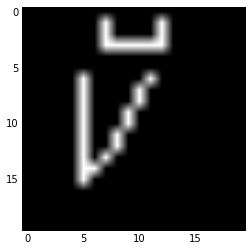

In [6]:
x=x_image[0][0]
type(x)
x_img_reshaped=np.reshape(x,(args.image_height,args.image_width))
plt.imshow(x_img_reshaped,cmap='gray')

In [7]:
print(x_label.shape)

(2, 6, 3)


In [8]:
x_label[0]

array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]])

In [9]:
x_label[1]

array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.]])

In [10]:
print(y.shape) #one-hot

(2, 6, 3)


In [11]:
y

array([[[ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]],

       [[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 1.,  0.,  0.],
        [ 0.,  1.,  0.]]], dtype=float32)

In [120]:
data_dir='/home/himani/data/omniglot_raw'
image_size=(100,100) #(args.image_height, args.image_width)
n_train_classses=args.n_train_classes
n_test_classes=args.n_test_classes

data = []

for dirname, subdirname, filelist in os.walk(data_dir):
    if filelist:
        data.append([Image.open(dirname + '/' + filename).copy() for filename in filelist])

print(len(data))
train_data = data[:n_train_classses]

#check if disjoint
print(len(data[n_train_classses:]))
test_data = data[-n_test_classes:]

1623
423


In [178]:
def one_hot_encode(x, dim):
    res = np.zeros(np.shape(x) + (dim, ), dtype=np.float32)
    it = np.nditer(x, flags=['multi_index'])
    while not it.finished:
        res[it.multi_index][it[0]] = 1
        it.iternext()
    return res

def augment(image, batch, c, only_resize=False,max_rotate=7,max_translate=7):
    if only_resize:
        image = ImageOps.invert(image.convert('L')).resize(image_size,resample=Image.BICUBIC)
        print('only resize')
    else:
        #max rotate is 7 degrees
        rand_rotate=(np.random.rand()-0.5)*2*max_rotate 
        #max translate is 7 pixels
        rand_translate=(np.random.rand(2)-0.5)*2*max_translate # (-7,7) -> (x_translation,y_translation)
        
        image = ImageOps.invert(image.convert('L')) \
                .rotate(rand_rotate) \
                .transform(image.size, Image.AFFINE, (1, 0, rand_translate[0], 0, 1, rand_translate[1])) \
                .resize(image_size,resample=Image.BILINEAR)   # rotate between (-7,7), translate bewteen (-7,7) 
    
    np_image = np.reshape(np.array(image, dtype=np.float32),
                        newshape=(image_size[0] * image_size[1]))

    max_value = np.max(np_image)    # normalization is important
    if max_value > 0.:
        np_image = np_image / max_value
    return np_image

In [179]:
np.random.seed(100)
random.seed(100)
image_size=(20,20)

In [180]:
n_classes=args.n_classes
batch_size=args.batch_size
seq_length=args.seq_length
mode=args.mode
sample_strategy='uniform'
augment_flag=False #args.augment
label_type=args.label_type

if mode == 'train':
    data = train_data
elif mode == 'test':
    data = test_data

classes = [np.random.choice(range(len(data)), replace=False, size=n_classes) for _ in range(batch_size)]

if sample_strategy == 'random':         # #(sample) per class may not be equal (sec 7)
    seq = np.random.randint(0, n_classes, [batch_size, seq_length])
elif sample_strategy == 'uniform':      # #(sample) per class are equal
    seq = np.array([np.concatenate([[j] * int(seq_length / n_classes) for j in range(n_classes)])
                    for i in range(batch_size)])
    for i in range(batch_size):
        np.random.shuffle(seq[i, :])

#rand_rotate_init(n_classes, batch_size)
seq_pic = [[augment(data[classes[i][j]][np.random.randint(0, len(data[classes[i][j]]))],
                    batch=i, c=j,only_resize=not augment_flag) 
            for j in seq[i, :]] 
           for i in range(batch_size)]

if label_type == 'one_hot':
    seq_encoded = one_hot_encode(seq, n_classes)
    seq_encoded_shifted = np.concatenate(
        [np.zeros(shape=[batch_size, 1, n_classes]), seq_encoded[:, :-1, :]], axis=1)

elif label_type == 'five_hot':
    label_dict = [[[int(j) for j in list(baseN(i, 5)) + [0] * (5 - len(baseN(i, 5)))]
                   for i in np.random.choice(range(5 ** 5), replace=False, size=n_classes)]
                  for _ in range(batch_size)]
    
    seq_encoded_ = np.array([[label_dict[b][i] for i in seq[b]] for b in range(batch_size)])
    seq_encoded = np.reshape(one_hot_encode(seq_encoded_, dim=5), newshape=[batch_size, seq_length, -1])
    seq_encoded_shifted = np.concatenate(
        [np.zeros(shape=[batch_size, 1, 25]), seq_encoded[:, :-1, :]], axis=1)
    
#return seq_pic, seq_encoded_shifted, seq_encoded

only resize
only resize
only resize
only resize
only resize
only resize
only resize
only resize
only resize
only resize
only resize
only resize


In [181]:
print(len(seq_pic))
print(len(seq_pic[0]))
print(seq_pic[0][0].shape)

2
6
(400,)


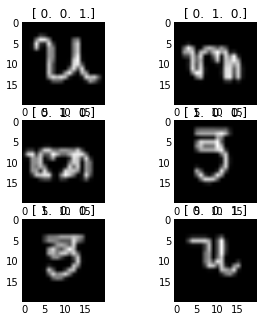

In [184]:
fig=plt.figure(figsize=(5,5))

for i in range(0,6):
    img=np.reshape(seq_pic[0][i],image_size)
    plt.subplot(3,2,i)
    plt.imshow(img,cmap='gray')
    plt.title(str(seq_encoded[0][i]))

In [185]:
img

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  

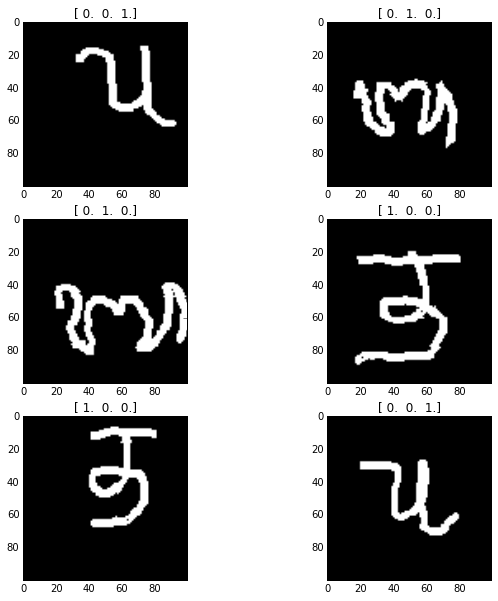

In [67]:
fig=plt.figure(figsize=(10,10))

for i in range(0,6):
    img=np.reshape(seq_pic[0][i],image_size)
    plt.subplot(3,2,i)
    plt.imshow(img,cmap='gray')
    plt.title(str(seq_encoded[0][i]))

In [21]:
n_classes=args.n_classes
batch_size=args.batch_size
seq_length=args.seq_length
mode=args.mode
sample_strategy='uniform'
augment_flag=True #args.augment
label_type=args.label_type

if mode == 'train':
    data = train_data
elif mode == 'test':
    data = test_data

In [16]:
print(len(data))

1200


In [17]:
classes = [np.random.choice(range(len(data)), replace=False, size=n_classes) for _ in range(batch_size)]
print(classes)

[array([114, 679, 253]), array([804, 144, 425])]


In [18]:
#for uniform
seq = np.array([np.concatenate([[j] * int(seq_length / n_classes) for j in range(n_classes)])
                    for i in range(batch_size)])
print(seq)

[[0 0 1 1 2 2]
 [0 0 1 1 2 2]]


In [19]:
for i in range(batch_size):
    np.random.shuffle(seq[i, :])
print(seq)

[[1 2 1 0 2 0]
 [2 2 1 0 1 0]]


In [24]:
seq_pic = [[augment(data[classes[i][j]][np.random.randint(0, len(data[classes[i][j]]))],
                    batch=i, c=j,only_resize=not augment_flag) 
            for j in seq[i, :]] 
           for i in range(batch_size)]

In [25]:
print(len(seq_pic))
print(len(seq_pic[0]))
print(seq_pic[0][0].shape)

2
6
(400,)


In [26]:
#one-hot
seq_encoded = one_hot_encode(seq, n_classes)

In [27]:
seq

array([[1, 2, 1, 0, 2, 0],
       [2, 2, 1, 0, 1, 0]])

In [28]:
seq_encoded

array([[[ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 1.,  0.,  0.]],

       [[ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 1.,  0.,  0.]]], dtype=float32)

In [29]:
seq_encoded_shifted = np.concatenate(
        [np.zeros(shape=[batch_size, 1, n_classes]), seq_encoded[:, :-1, :]], axis=1)

In [30]:
seq_encoded_shifted

array([[[ 0.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  1.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  1.,  0.]]])